In [1]:
using Revise
# import Pkg; Pkg.status()

In [2]:
import PyCall

import OccGrid as O
import PointCloud as PC

# If undefined: (@v1.6) pkg> dev PointCloud
import PointCloud: CameraIntrinsics

import Control: BeliefState, execute_command!
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
import Rotations
using StaticArrays

global MCS = PyCall.pyimport("machine_common_sense")
global np = PyCall.pyimport("numpy")

PyObject <module 'numpy' from '/usr/local/lib/python3.8/dist-packages/numpy/__init__.py'>

In [3]:
cora_path = get(ENV, "CORA_PATH", "/cora")
cora_agent_path = joinpath(cora_path, "cora-agent")
scene_path = joinpath(cora_agent_path, "test/data/eval5/ball_behind_sofa.json")
config_path = joinpath(cora_agent_path, "test/data/config_level2.ini")

if "MCS_CONFIG_FILE_PATH" ∈ keys(ENV)
    println("\nWARNING: MCS_CONFIG_FILE_PATH is set and might interfere with your defined information level.")
end

if isfile(config_path)
    controller = MCS.create_controller(config_file_or_dict=config_path)
else
    println("Error: Config file path \"$(config_path)\" does not exist.")
end

if isfile(scene_path)
    scene_config = MCS.load_scene_json_file(scene_path);
else
    println("Error: Scene path \"$(scene_path)\" does not exist.")
end

# Agent starts in (3, 3) without rotation
# scene_config["performerStart"]["position"] = Dict{Any, Any}("x"=>0, "z"=>0) would be in sofa

Found path: /root/.mcs/0.5.2/MCS-AI2-THOR-Unity-App-v0.5.2.x86_64


Dict{Any, Any} with 8 entries:
  "performerStart"  => Dict{Any, Any}("rotation"=>Dict{Any, Any}("x"=>0, "y"=>0…
  "name"            => "soccer_ball_retrieval_example"
  "floorMaterial"   => "AI2-THOR/Materials/Fabrics/CarpetWhite 3"
  "ceilingMaterial" => "AI2-THOR/Materials/Walls/Drywall"
  "objects"         => Dict{Any, Any}[Dict("salientMaterials"=>["fabric"], "mat…
  "wallMaterial"    => "AI2-THOR/Materials/Walls/DrywallBeige"
  "goal"            => Dict{Any, Any}("metadata"=>Dict{Any, Any}("target"=>Dict…
  "version"         => 2

In [4]:
step_metadata = controller.start_scene(scene_config)

PyObject <machine_common_sense.step_metadata.StepMetadata object at 0x7fae05f6c520>

In [5]:
intrinsics = CameraIntrinsics(step_metadata)

Geometry.CameraIntrinsics
  width: Int64 600
  height: Int64 400
  fx: Float64 514.2991467983065
  fy: Float64 514.2991467983065
  cx: Float64 300.0
  cy: Float64 200.0
  near: Float64 9.999999747378752e-5
  far: Float64 9999.0


In [6]:
belief_state = BeliefState(
    intrinsics=intrinsics,
    step_metadata_history=[step_metadata],
    action_history=[],
    pose_history=[IDENTITY_POSE],
    information_level="level2",
    time_to_live=0
);

# obs = [step_metadata] ∪ [execute_command!(controller, belief_state, "RotateRight") for _  in 1:35];
for _  in 1:35
    execute_command!(controller, belief_state, "RotateRight")
end

In [7]:
# PC.realign_world!(belief_state)

In [8]:
occupancy_grid_config = O.OccupancyGridConfig(SVector{3, Float64}([0.1, 0.1, 0.1]))
occupancy_grid = O.OccupancyGrid(occupancy_grid_config)

OccGrid.OccupancyGrid(OccGrid.OccupancyGridConfig([0.1, 0.1, 0.1], 1), Dict{SVector{3, Int64}, Int64}(), Dict{SVector{3, Int64}, Int64}(), [0, 0, 0], [0, 0, 0], [0, 0, 0])

In [9]:
objects_only_cloud, world_bbox, perception_updated_until = PC.perception_initializiation(belief_state, occupancy_grid, 1, length(belief_state.pose_history));

## Render Naively
The following will render the `objects_only_cloud` just extracted.

In [10]:
import Images as I
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

V.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /root/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


Could not open browser automatically: Base.IOError("could not spawn `xdg-open http://127.0.0.1:8702`: no such file or directory (ENOENT)", -2)
Please open the following URL in your browser:
http://127.0.0.1:8702


In [11]:
V.viz(objects_only_cloud[1:3, :] ./ 5.0; color=I.colorant"black", channel_name=:gen_cloud)

MeshCat Visualizer with path /meshcat/gen_cloud at http://127.0.0.1:8702

## Compute Mesh
The following will turn the object point cloud into a mesh and render out a depth map based on it.

In [12]:
import GLRenderer as GL
import InverseGraphics as T
import PoseComposition  # Temp?
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN, QuatRotation, RotZYX

function get_cloud(poses, ids, camera_pose)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, camera)
    if isnothing(cloud)
        cloud = zeros(3,1)
    end
    cloud
end

get_cloud (generic function with 1 method)

In [13]:
function GlCameraIntrinsics(step_metadata::PyCall.PyObject)::GL.CameraIntrinsics
    width, height = step_metadata.camera_aspect_ratio
    aspect_ratio = width / height

    # Camera principal point is the center of the image.
    cx, cy = width / 2.0, height / 2.0

    # Vertical field of view is given.
    fov_y = deg2rad(step_metadata.camera_field_of_view)
    # Convert field of view to distance to scale by aspect ratio and
    # convert back to radians to recover the horizontal field of view.
    fov_x = 2 * atan(aspect_ratio * tan(fov_y / 2.0))

    # Use the following relation to recover the focal length:
    #   FOV = 2 * atan( (0.5 * IMAGE_PLANE_SIZE) / FOCAL_LENGTH )
    fx = cx / tan(fov_x / 2.0)
    fy = cy / tan(fov_y / 2.0)

    # clipping_near, clipping_far = step_metadata.camera_clipping_planes
    # TODO Picking planes appropriately seems non-trivial
    clipping_near, clipping_far = 0.1, 11.2

    GL.CameraIntrinsics(width, height,
        fx, fy, cx, cy,
        clipping_near, clipping_far)
end

# Instead of YCB camera scaled down by factor 4, use MCS camera without scaling
# camera = T.scale_down_camera(original_camera, 4)
camera = GlCameraIntrinsics(step_metadata)
renderer = GL.setup_renderer(camera, GL.DepthMode())

gl_version_for_shaders = "410"
true


GLRenderer.Renderer{GLRenderer.DepthMode}(GLFW.Window(Ptr{Nothing} @0x000000000ea8c740), GLRenderer.CameraIntrinsics
  width: Int64 600
  height: Int64 400
  fx: Float64 514.2991467983065
  fy: Float64 514.2991467983065
  cx: Float64 300.0
  cy: Float64 200.0
  near: Float64 0.1
  far: Float64 11.2
, 0x00000003, Any[], Any[], Any[], Float32[1.7143304 0.0 0.0 0.0; 0.0 2.5714955 0.0 0.0; 0.0 0.0 -1.018018 -0.20180179; 0.0 0.0 -1.0 0.0])

In [14]:
# camera.near = intrinsics.near
# step_metadata.camera_clipping_planes

In [15]:
V.reset_visualizer()

MeshCat Visualizer with path /meshcat at http://127.0.0.1:8702

In [16]:
resolution = 0.1

voxel_grid = GL.voxelize(objects_only_cloud[1:3, :], resolution)

l = [keys(occupancy_grid.occupied_cell_map)...]
voxel_grid2 = transpose(np.stack(l)) .* 0.1


mesh = GL.mesh_from_voxelized_cloud(voxel_grid2, resolution)
GL.load_object!(renderer, mesh)

true

In [17]:
minimum(voxel_grid[3,:]), maximum(voxel_grid[3,:])  # -8 to 2, -2.2 to 0.7, -8 to 2

(-8.0, 2.0)

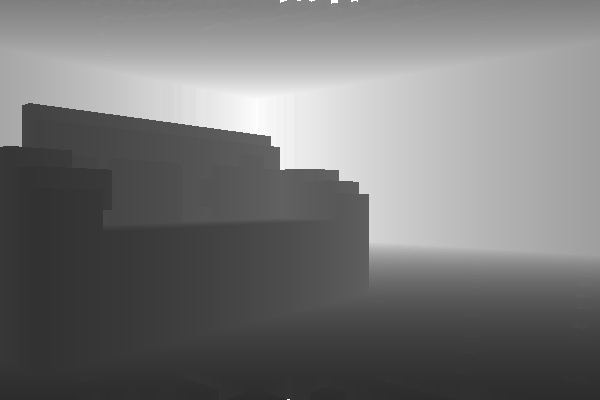

In [18]:
ids = [1]
time_step = 24
pose_mcs = belief_state.pose_history[time_step]

# Cora uses Euler angle order YPR (zxy) in radians, left-handed -> right-handed => invert sign
pose = Pose(pose_mcs.pos, Rotations.RotZXY(0, 0, -Rotations.RotZXY(pose_mcs.orientation).theta3))  # 130.0

depth_image = GL.gl_render(renderer, ids, [pose], IDENTITY_POSE)
GL.view_depth_image(clamp.(depth_image, 0.0, 200.0))

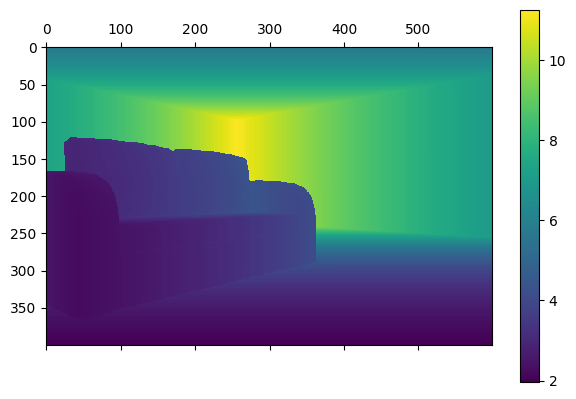

In [19]:
PyCall.py"""
import matplotlib.pyplot as plt

def matshow(mat):
    plt.matshow(mat)
    plt.colorbar()
"""

depth_map_gt = last(belief_state.step_metadata_history[time_step].depth_map_list)  # Good point to try error, e.g. time_step - 10
PyCall.py"matshow"(depth_map_gt)
# RGB: last(belief_state.step_metadata_history[24].image_list)

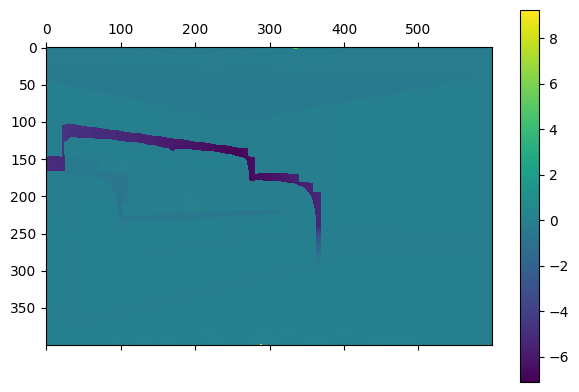

In [20]:
diff = depth_image - depth_map_gt
PyCall.py"matshow"(diff)

In [21]:
min_rendered, max_rendered = minimum(depth_image), maximum(depth_image)
min_gt, max_gt = minimum(depth_map_gt), maximum(depth_map_gt)
println("$(min_rendered) to $(max_rendered) versus $(min_gt) to $(max_gt)")
# max_a / max_b

1.933438982071206 to 11.200000000000038 versus 1.9668484 to 11.259877


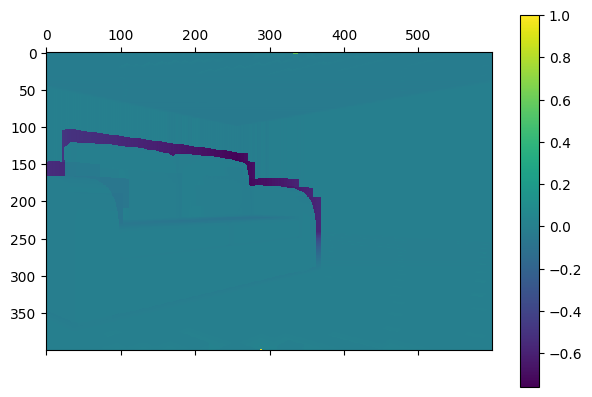

0.0 to 1.0 versus 0.0 to 1.0


In [22]:
# Naive metric: Scale both to [0,1] and compare
depth_image_normalized = (depth_image .- min_rendered) / (max_rendered - min_rendered)
depth_map_gt_normalized = (depth_map_gt .- min_gt) / (max_gt - min_gt)
diff2 = depth_image_normalized .- depth_map_gt_normalized

min_rendered_normalized, max_rendered_normalized = minimum(depth_image_normalized), maximum(depth_image_normalized)
min_gt_normalized, max_gt_normalized = minimum(depth_map_gt_normalized), maximum(depth_map_gt_normalized)
println("$(min_rendered_normalized) to $(max_rendered_normalized) versus $(min_gt_normalized) to $(max_gt_normalized)")

PyCall.py"matshow"(diff2)

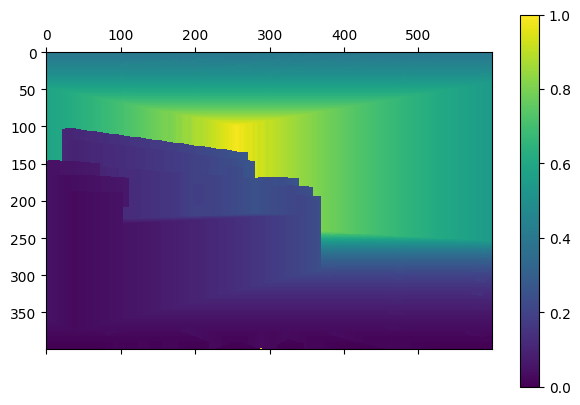

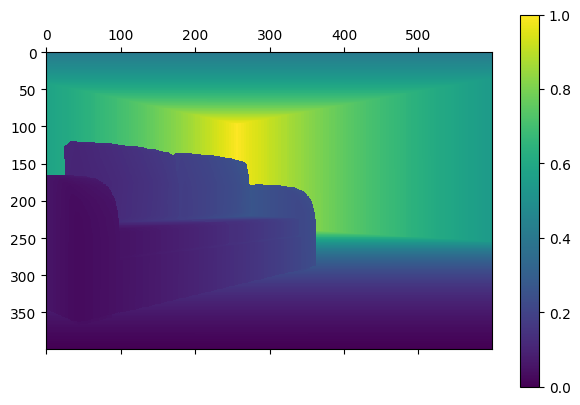

In [23]:
PyCall.py"matshow"(depth_image_normalized)
PyCall.py"matshow"(depth_map_gt_normalized)

In [24]:
sum(abs.(diff2)) / prod(size(diff2))

0.021444755475903295